# First stage of Sempli project: Cleaning the data

In [31]:
import pandas as pd
import numpy as np
import json
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import scipy.stats
import flat_table
# Configuración de pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Loading the data

In this part of the project we are loading the excel file and normalizing the json format presented in the columns 'expected_detail' and 'paid_detail'

After normalizing the data we delete rows where the state of the client were 'GRACE' or 'PENDING' because of the COVID situation present at the moment of the study ('GRACE'), and the missing values presented on 'PENDING'

In [32]:
path_file = "loan_schedules_2.xlsx"
cols = ['client_id',
        'loan_schedule_id',
        'loan_id',
        'index',
        'expected_date',
        'state',
        'arrears_days',
        'expected_detail',
        'paid_detail']
data = pd.read_excel(path_file, sheet_name = 0, header = 0, usecols = cols).replace('NaT', np.nan)
data['expected_detail'] = data['expected_detail'].apply(lambda x: "{}" if pd.isna(x) else x)
data['paid_detail'] = data['paid_detail'].apply(lambda x: "{}" if pd.isna(x) else x)

def normalize_data(df, col_name):
    data = df[col_name].apply(json.loads)
    return pd.json_normalize(data)

expected = normalize_data(data,'expected_detail')
expected.head(10)
paid = normalize_data(data,'paid_detail')
data = data.join(expected).join(paid, rsuffix='_paid')
data = data[data.state != "GRACE"]
data = data[data.state != "PENDING"]
data = data[data.state != "PARTIALLY_PAID"]
#data = data[data.expected_date < '2020-04-01']
data.head(10)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,expected_detail,paid_detail,total,penalty,interest,insurance,principal,taxRetentionValue,taxRetentionPercentage,fngTotal,fngValue,fngPercent,fngVatValue,legalCharge,fngVatPercent,preLegalCharge,feesPaid,monthlyDeferredInterest,total_paid,penalty_paid,interest_paid,insurance_paid,principal_paid,taxRetentionValue_paid,taxRetentionPercentage_paid,fngTotal_paid,fngValue_paid,fngPercent_paid,fngVatValue_paid,legalCharge_paid,fngVatPercent_paid,preLegalCharge_paid,feesPaid_paid,monthlyDeferredInterest_paid
1,2442,13696,592,6,2019-03-18,PAID,0,"{""total"": 22872996.50, ""penalty"": 0, ""interest...","{""total"": 22872996.50, ""penalty"": 0, ""interest...",22872996.50,0.0,358105.48,0.0,22514891.02,14324.2192,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22872996.50,0.0,358105.48,0.0,22514891.02,0.0,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9273,43776,1831,3,2020-03-04,PAID,5,"{""total"": 7322168.42, ""penalty"": 0, ""fngTotal""...","{""total"": 7322168.42, ""penalty"": 0, ""fngTotal""...",7322168.42,0.0,3015180.80,59878.0,4306987.62,120607.2320,0.04,0.0,0.0,0.028,0.0,NaN,0.19,NaN,NaN,NaN,7322168.42,0.0,3015180.80,0.0,4306987.62,0.0,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2952,25418,1065,2,2019-02-12,PAID,0,"{""total"": 4264953.71, ""penalty"": 0, ""feesPaid""...","{""total"": 4264953.71, ""penalty"": 0, ""feesPaid""...",4264953.71,0.0,1519955.30,29939.0,2744998.41,60798.2120,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4264953.71,0.0,1519955.30,0.0,2744998.41,0.0,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2459,14548,628,13,2019-11-19,LATE,76,{},{},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4458,31214,1320,6,2019-11-27,PAID,0,"{""total"": 2598166.29, ""penalty"": 0, ""feesPaid""...","{""total"": 2598166.29, ""penalty"": 0, ""feesPaid""...",2598166.29,0.0,493134.76,10828.0,2105031.53,19725.3904,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2598166.29,0.0,493134.76,0.0,2105031.53,0.0,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,459,13387,579,4,2018-07-03,PAID,0,"{""total"": 7436536.26, ""penalty"": 0, ""interest""...","{""total"": 7436536.26, ""penalty"": 0, ""interest""...",7436536.26,0.0,1802869.08,0.0,5633667.18,72114.7632,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7436536.26,0.0,1802869.08,0.0,5633667.18,0.0,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2459,14544,628,9,2019-07-19,LATE,199,{},{},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1021,16366,706,8,2019-07-30,PAID,3,"{""total"": 2913186.24, ""penalty"": 0, ""feesPaid""...","{""total"": 2913186.24, ""penalty"": 0, ""feesPaid""...",2913186.24,0.0,221100.10,0.0,2692086.14,8844.0040,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2913186.24,0.0,221100.10,0.0,2692086.14,0.0,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,6206,38154,1611,2,2019-11-12,PAID,0,"{""total"": 3040866.75, ""penalty"": 0, ""interest""...","{""total"": 3040866.75, ""penalty"": 0, ""interest""...",3040866.75,0.0,975854.45,17963.0,2065012.30,39034.1780,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3040866.75,0.0,975854.45,0.0,2065012.30,0.0,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,6206,38155,1611,3,2019-12-11,PAID,0,"{""total"": 3040866.75, ""penalty"": 0, ""interest""...","{""total"": 3040866.75, ""penalty"": 0, ""interest""...",3040866.75,0.0,880358.39,17963.0,2160508.36,35214.3356,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3040866.75,0.0,880358.39,0.0,2160508.36,0.0,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Deleting unnecessary columns

After taking a look at the data, we came to the conclusion to use total_paid and total_expected values and delete the other variable presented on 'data_droped_columns'

In [33]:
data_droped_columns = ['penalty', 'interest', 'insurance', 'principal', 'taxRetentionValue',
                       'taxRetentionPercentage', 'legalCharge', 'preLegalCharge', 'feesPaid',
                       'fngTotal', 'fngValue',
                       'fngPercent', 'fngVatValue', 'fngVatPercent', 'monthlyDeferredInterest',
                       'penalty_paid', 'interest_paid', 'insurance_paid',
                       'principal_paid', 'taxRetentionValue_paid',
                       'taxRetentionPercentage_paid', 'legalCharge_paid',
                       'preLegalCharge_paid', 'feesPaid_paid', 'fngTotal_paid',
                       'fngValue_paid', 'fngPercent_paid', 'fngVatValue_paid',
                       'fngVatPercent_paid', 'monthlyDeferredInterest_paid']
data = data.drop(columns=data_droped_columns)
data.head(2)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,expected_detail,paid_detail,total,total_paid
1,2442,13696,592,6,2019-03-18,PAID,0,"{""total"": 22872996.50, ""penalty"": 0, ""interest...","{""total"": 22872996.50, ""penalty"": 0, ""interest...",22872996.50,22872996.50
2,9273,43776,1831,3,2020-03-04,PAID,5,"{""total"": 7322168.42, ""penalty"": 0, ""fngTotal""...","{""total"": 7322168.42, ""penalty"": 0, ""fngTotal""...",7322168.42,7322168.42


### checking normalized values
After deleting the some columns, we check if the 'total' and 'total_paid' match to the one on 'expected_detail' for 'total' and 'paid_detail' for 'total_paid'

The next step is delete the rows with json format and organize the data by 'client_id'

In [34]:
unused_columns = ['expected_detail', 'paid_detail']
data = data.drop(columns=unused_columns)
data = data.sort_values(by='client_id', ascending=True)
data.head(2)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,total,total_paid
5477,14,77,14,3,2017-07-27,PAID,0,1497723.06,1497723.06
861,14,82,14,8,2017-12-27,PAID,0,1497723.06,1497723.06


### Analyzing by loan ID 

At this stage we agreed to analyze how's the payment by loan_id on the last 6 months

In [35]:
data = data.sort_values(['client_id', 'loan_id', 'expected_date'])
data = data.groupby('loan_id').filter(lambda x : x['loan_id'].value_counts() > 6).groupby('loan_id').tail(6)
data.head(10)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,total,total_paid
5677,14,80,14,6,2017-10-27,PAID,4,1497723.06,1497723.06
860,14,81,14,7,2017-11-27,PAID,0,1499416.03,1499416.03
861,14,82,14,8,2017-12-27,PAID,0,1497723.06,1497723.06
862,14,83,14,9,2018-01-29,PAID,0,1497723.06,1497723.06
863,14,84,14,10,2018-02-27,PAID,0,20078872.73,20078872.73
233,14,85,14,11,2018-03-27,PAID,0,20018.84,20018.84
3742,141,2863,200,11,2019-08-26,PAID,0,30141765.76,30141765.76
3743,141,2864,200,12,2019-09-25,PAID,0,661183.89,661183.89
4954,141,2865,200,13,2019-10-25,PAID,0,661183.89,661183.89
4956,141,2866,200,14,2019-11-25,PAID,0,661183.89,661183.89


### Ploting the state behaviour of the clients

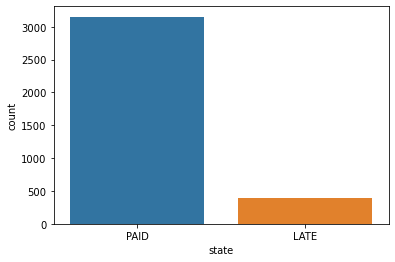

In [36]:
sns.countplot(x='state', data= data)

In [37]:
data.state.value_counts()

PAID    3152
LATE     400
Name: state, dtype: int64

## Export data dataframe to an excel file

In [38]:
#data.to_excel('output.xlsx')

### Loading cathegorical data

In [39]:
path_file = "data_sempli_holberton.xlsx"
cat_cols = ['ID Cliente', 'Monto Acumulado', 'Uso de los recursos', 'Plazo',
       'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo',
       'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Tiempo en el negocio',
       'Website empresa', 'Instagram empresa', 'LinkedIn empresa',
       'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas',
       'Impacto', 'Acceso previso a la banca', '# Empleados',
       'Mujeres empresarias', 'Mujeres en cargos directivos']
cat_data = pd.read_excel(path_file, sheet_name = 0, header = 2, usecols = cat_cols).replace('SIN INFO', np.nan)
cat_data = cat_data.dropna()
cat_data.head(3)

,ID Cliente,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Tiempo en el negocio,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
0,7154.0,100000000,SP,25 a 36 meses,Industria,Scale Up,Medellín,4,Sí procesos judiciales,Sí Alertas,909.0,8.0,1987,Si website,Si Ig,No LinkedIn,Si LinkedIn empresarios,57,Referrer,8.0,No Impacto,Si acceso a la banca,77,Si mujeres empresarias,3
1,646.0,320000000,KT - CO,Menos de 12 meses,Servicios,Scale Up,Medellín,4,No procesos judiciales,No Alertas,937.0,0.0,1987,Si website,No Ig,No LinkedIn,Si LinkedIn empresarios,36,Other,3.0,No Impacto,Si acceso a la banca,35,No mujeres empresarias,2
2,3934.0,300000000,SP,25 a 36 meses,Servicios,Scale Up,Medellín,5,No procesos judiciales,No Alertas,933.0,11.0,1992,Si website,Si Ig,No LinkedIn,No LinkedIn empresarios,46,Other,5.0,No Impacto,No acceso a la banca,60,No mujeres empresarias,3


In [40]:
cat_data = cat_data.sort_values(by='ID Cliente', ascending=True)
cat_data.head(2)

,ID Cliente,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Tiempo en el negocio,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
269,98.0,30000000,KT - EX,13 a 24 meses,Servicios,Venture,Bogotá D.C.,5,No procesos judiciales,No Alertas,0.0,0.0,2013,No website,No Ig,No LinkedIn,No LinkedIn empresarios,30,Internet,1.0,Si Impacto,Si acceso a la banca,110,No mujeres empresarias,3
529,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No procesos judiciales,No Alertas,925.0,8.0,2016,Si website,Si Ig,Si LinkedIn,Si LinkedIn empresarios,45,Internet,2.0,No Impacto,Si acceso a la banca,16,No mujeres empresarias,2


In [41]:
rep_columns = ['Procesos judiciales', 'Alertas', 'Website empresa',
               'Instagram empresa', 'LinkedIn empresa',
               'LinkedIn empresarios', 'Impacto', 'Acceso previso a la banca',
               'Mujeres empresarias']

cat_data[rep_columns] = cat_data[rep_columns].replace({'No procesos judiciales':'No',
                                                           'Sí procesos judiciales':'Si',
                                                           'No Alertas':'No',
                                                           'Sí Alertas': 'Si',
                                                           'No website':'No',
                                                           'Si website':'Si',
                                                           'No Ig':'No',
                                                           'Si Ig':'Si',
                                                           'No LinkedIn':'No',
                                                           'Si LinkedIn':'Si',
                                                           'No LinkedIn empresarios':'No',
                                                           'Si LinkedIn empresarios':'Si',
                                                           'Si Impacto':'Si',
                                                           'No Impacto':'No',
                                                           'Si acceso a la banca':'Si',
                                                           'No acceso a la banca':'No',
                                                           'No mujeres empresarias':'No',
                                                           'Si mujeres empresarias':'Si'})
cat_data.head(2)

,ID Cliente,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Tiempo en el negocio,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
269,98.0,30000000,KT - EX,13 a 24 meses,Servicios,Venture,Bogotá D.C.,5,No,No,0.0,0.0,2013,No,No,No,No,30,Internet,1.0,Si,Si,110,No,3
529,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2


In [42]:
clean_data = pd.DataFrame()
clean_data = data.merge(cat_data, left_on='client_id', right_on='ID Cliente')
clean_data.head(10)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,total,total_paid,ID Cliente,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Tiempo en el negocio,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
0,241,25718,1076,8,2019-08-14,PAID,16,5.947505e+06,5.947505e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
1,241,25719,1076,9,2019-09-16,PAID,1,5.972930e+06,5.972930e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
2,241,25720,1076,10,2019-10-30,PAID,0,5.941645e+06,5.941645e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
3,241,25721,1076,11,2019-11-29,PAID,0,5.939653e+06,5.939653e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
4,241,25722,1076,12,2019-12-30,PAID,0,5.939653e+06,5.939653e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
5,241,25723,1076,13,2020-01-30,PAID,0,1.181744e+08,1.181744e+08,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
6,241,29424,1244,4,2019-08-12,PAID,18,3.331876e+06,3.331876e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
7,241,29425,1244,5,2019-09-12,PAID,5,3.343649e+06,3.343649e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
8,241,29426,1244,6,2019-10-30,PAID,0,3.329963e+06,3.329963e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
9,241,29427,1244,7,2019-11-29,PAID,0,3.324579e+06,3.324579e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2


In [43]:
clean_data['total'] = clean_data['total'].fillna(0)
clean_data['total_paid'] = clean_data['total_paid'].fillna(0)
clean_data.head(10)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,total,total_paid,ID Cliente,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Tiempo en el negocio,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
0,241,25718,1076,8,2019-08-14,PAID,16,5.947505e+06,5.947505e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
1,241,25719,1076,9,2019-09-16,PAID,1,5.972930e+06,5.972930e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
2,241,25720,1076,10,2019-10-30,PAID,0,5.941645e+06,5.941645e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
3,241,25721,1076,11,2019-11-29,PAID,0,5.939653e+06,5.939653e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
4,241,25722,1076,12,2019-12-30,PAID,0,5.939653e+06,5.939653e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
5,241,25723,1076,13,2020-01-30,PAID,0,1.181744e+08,1.181744e+08,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
6,241,29424,1244,4,2019-08-12,PAID,18,3.331876e+06,3.331876e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
7,241,29425,1244,5,2019-09-12,PAID,5,3.343649e+06,3.343649e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
8,241,29426,1244,6,2019-10-30,PAID,0,3.329963e+06,3.329963e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
9,241,29427,1244,7,2019-11-29,PAID,0,3.324579e+06,3.324579e+06,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2


In [44]:
clean_data.shape

(3462, 34)

In [45]:
clean_data.to_excel('random_data.xlsx')

## Data Analysis

In [46]:
clean_data.isnull().any()

client_id                       False
loan_schedule_id                False
loan_id                         False
index                           False
expected_date                   False
state                           False
arrears_days                    False
total                           False
total_paid                      False
ID Cliente                      False
Monto Acumulado                 False
Uso de los recursos             False
Plazo                           False
Sector                          False
Ingresos                        False
Ubicación                       False
Estrato Mínimo                  False
Procesos judiciales             False
Alertas                         False
Score Bureau Empresa            False
Huellas de Consulta             False
Tiempo en el negocio            False
Website empresa                 False
Instagram empresa               False
LinkedIn empresa                False
LinkedIn empresarios            False
Edad empresa

In [47]:
#clean_data['paid_date'].isnull().value_counts()/len(clean_data)

In [48]:
len(clean_data)

3462

In [49]:
clean_data.head(2)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,total,total_paid,ID Cliente,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Tiempo en el negocio,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
0,241,25718,1076,8,2019-08-14,PAID,16,5947504.88,5947504.88,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2
1,241,25719,1076,9,2019-09-16,PAID,1,5972929.73,5972929.73,241.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925.0,8.0,2016,Si,Si,Si,Si,45,Internet,2.0,No,Si,16,No,2


#### Analizing Cathegorical data

Text(0.5, 0.98, 'Frecuency of observation by Sector')

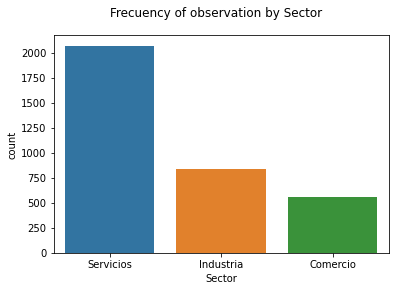

In [50]:
sns.countplot(x='Sector', data = clean_data)
plt.suptitle('Frecuency of observation by Sector')

The mayority of companies are from the 'Servicios' sector. Here you can see that there are way more companies from the 'Servicios' sector than from the 'Industria' and 'Comercio'

Text(0.5, 0.98, 'Frecuency of observation by Activador')

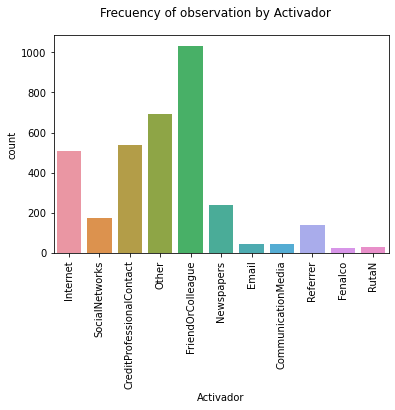

In [51]:
act_graph = sns.countplot(x='Activador', data = clean_data)
act_graph.set_xticklabels(act_graph.get_xticklabels(), rotation=90)
plt.suptitle('Frecuency of observation by Activador')

Text(0.5, 0.98, 'Frecuency of obervation by -Procesos Judiciales-')

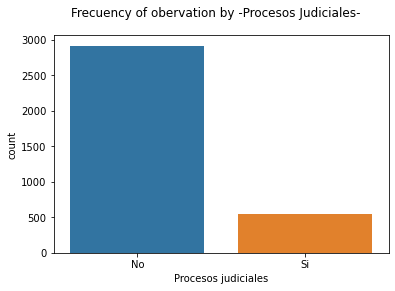

In [52]:
sns.countplot(x='Procesos judiciales', data = clean_data)
plt.suptitle('Frecuency of obervation by -Procesos Judiciales-')

Text(0.5, 0.98, 'Frecuency of obervation by -Ubicación-')

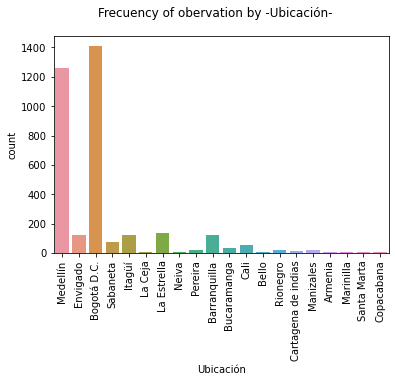

In [53]:
ubc_graph = sns.countplot(x='Ubicación', data = clean_data)
ubc_graph.set_xticklabels(ubc_graph.get_xticklabels(), rotation=90)
plt.suptitle('Frecuency of obervation by -Ubicación-')

Text(0.5, 0.98, 'Frecuency of observation by Ingresos')

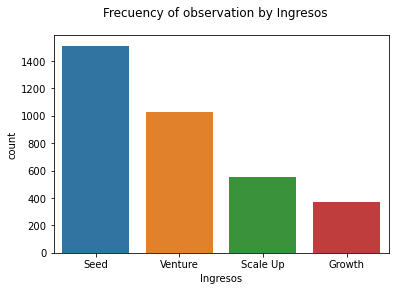

In [54]:
sns.countplot(x='Ingresos', data = clean_data)
plt.suptitle('Frecuency of observation by Ingresos')

Text(0.5, 0.98, 'Frecuency of observation by Uso de los recursos')

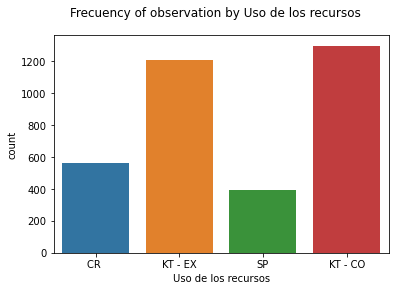

In [55]:
sns.countplot(x='Uso de los recursos', data = clean_data)
plt.suptitle('Frecuency of observation by Uso de los recursos')

Text(0.5, 0.98, 'Frecuency of observation by Instagram empresa')

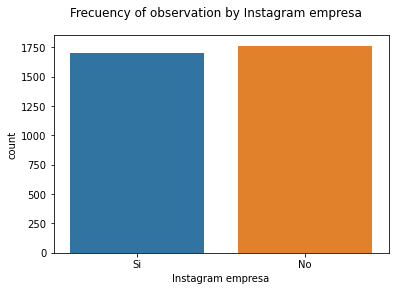

In [56]:
sns.countplot(x='Instagram empresa', data = clean_data)
plt.suptitle('Frecuency of observation by Instagram empresa')

Text(0.5, 0.98, 'Frecuency of observation by Website empresa')

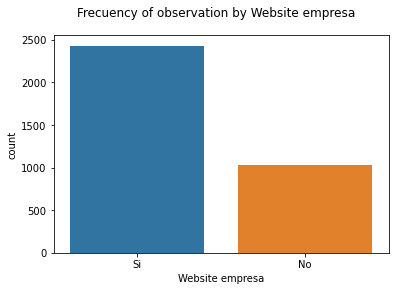

In [57]:
sns.countplot(x='Website empresa', data = clean_data)
plt.suptitle('Frecuency of observation by Website empresa')

Text(0.5, 0.98, 'Frecuency of observation by LinkedIn empresa')

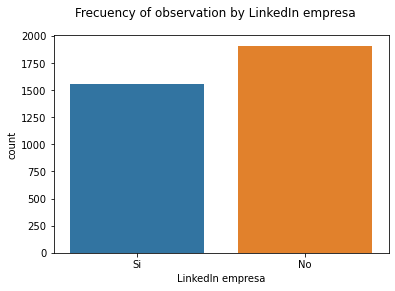

In [58]:
sns.countplot(x='LinkedIn empresa', data = clean_data)
plt.suptitle('Frecuency of observation by LinkedIn empresa')

Text(0.5, 0.98, 'Frecuency of observation by LinkedIn empresarios')

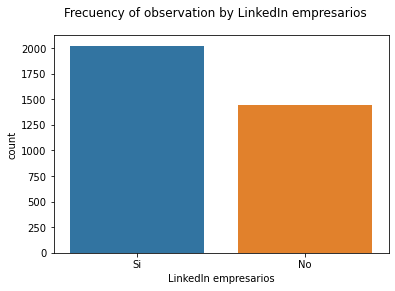

In [59]:
sns.countplot(x='LinkedIn empresarios', data = clean_data)
plt.suptitle('Frecuency of observation by LinkedIn empresarios')

#### Analizing Numerical data

In [60]:
clean_data['total_paid'].describe()

count    3.462000e+03
mean     6.629332e+06
std      1.216541e+07
min      0.000000e+00
25%      1.995612e+06
50%      3.788692e+06
75%      7.488615e+06
max      2.152136e+08
Name: total_paid, dtype: float64

Text(0.5, 0.98, 'Distribution of total_paid')

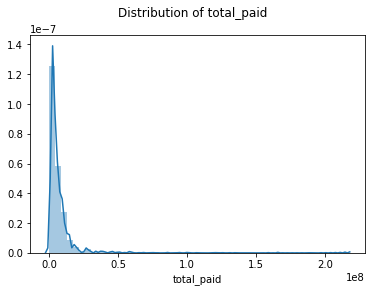

In [61]:
sns.distplot(clean_data['total_paid'])
plt.suptitle('Distribution of total_paid')

In [62]:
clean_data['total'].describe()

count    3.462000e+03
mean     6.629266e+06
std      1.216523e+07
min      0.000000e+00
25%      1.995612e+06
50%      3.788692e+06
75%      7.488615e+06
max      2.152136e+08
Name: total, dtype: float64

Text(0.5, 0.98, 'Distribution of total expected')

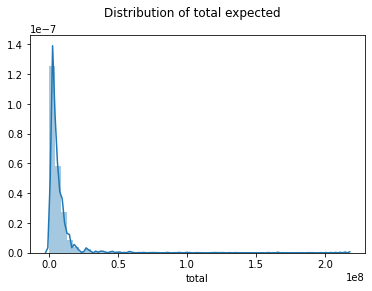

In [63]:
sns.distplot(clean_data['total'])
plt.suptitle('Distribution of total expected')

In [64]:
clean_data['arrears_days'].describe()

count    3462.000000
mean       11.827267
std        26.811544
min         0.000000
25%         0.000000
50%         1.000000
75%        11.000000
max       258.000000
Name: arrears_days, dtype: float64

Text(0.5, 0.98, 'Distribution of arrears_days')

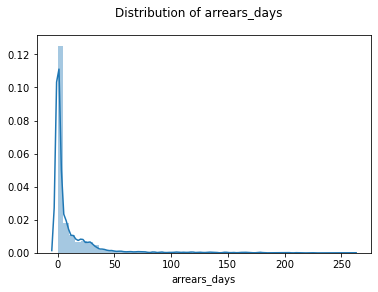

In [65]:
sns.distplot(clean_data['arrears_days'])
plt.suptitle('Distribution of arrears_days')

In [66]:
clean_data.columns

Index(['client_id', 'loan_schedule_id', 'loan_id', 'index', 'expected_date', 'state', 'arrears_days', 'total', 'total_paid', 'ID Cliente', 'Monto Acumulado', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo', 'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Tiempo en el negocio', 'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas', 'Impacto', 'Acceso previso a la banca', '# Empleados', 'Mujeres empresarias', 'Mujeres en cargos directivos'], dtype='object')

In [67]:
clean_data['Huellas de Consulta'].describe()

count    3462.000000
mean        7.353553
std         7.754006
min         0.000000
25%         2.000000
50%         4.000000
75%        10.000000
max        44.000000
Name: Huellas de Consulta, dtype: float64

Text(0.5, 0.98, 'Distribution of Huellas de Consulta')

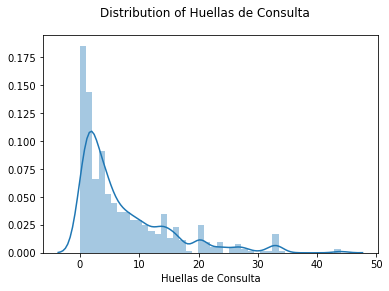

In [68]:
sns.distplot(clean_data['Huellas de Consulta'])
plt.suptitle('Distribution of Huellas de Consulta')

In [69]:
### Huellas de Consulta: Some rows are -SIN INFO-
# convertirlos a nan
# convertirlos en la media
# Borrarlos

In [70]:
# clean_data[clean_data['Huellas de Consulta'] == 'SIN INFO']

In [71]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3462 entries, 0 to 3461
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   client_id                     3462 non-null   int64         
 1   loan_schedule_id              3462 non-null   int64         
 2   loan_id                       3462 non-null   int64         
 3   index                         3462 non-null   int64         
 4   expected_date                 3462 non-null   datetime64[ns]
 5   state                         3462 non-null   object        
 6   arrears_days                  3462 non-null   int64         
 7   total                         3462 non-null   float64       
 8   total_paid                    3462 non-null   float64       
 9   ID Cliente                    3462 non-null   float64       
 10  Monto Acumulado               3462 non-null   int64         
 11  Uso de los recursos           

In [72]:
clean_data['Edad empresarios'].describe()

count    3462.000000
mean       41.131716
std        10.091863
min        22.000000
25%        33.000000
50%        40.000000
75%        46.000000
max        74.000000
Name: Edad empresarios, dtype: float64

Text(0.5, 0.98, 'Distribution of -Edad empresarios-')

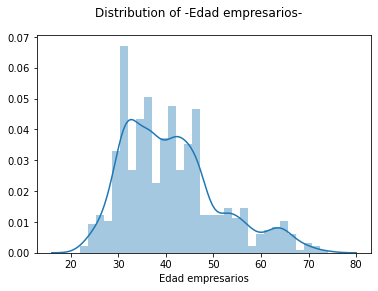

In [73]:
sns.distplot(clean_data['Edad empresarios'])
plt.suptitle('Distribution of -Edad empresarios-')

In [74]:
clean_data['Mujeres en cargos directivos'].describe()

count    3462.000000
mean        1.949740
std         2.531812
min         0.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        25.000000
Name: Mujeres en cargos directivos, dtype: float64

Text(0.5, 0.98, 'Distribution of -Mujeres en cargos directivos-')

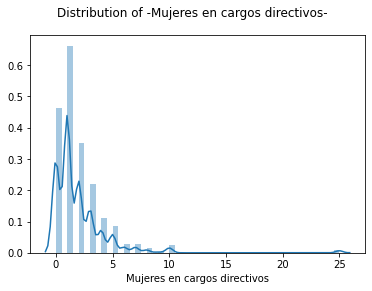

In [75]:
sns.distplot(clean_data['Mujeres en cargos directivos'])
plt.suptitle('Distribution of -Mujeres en cargos directivos-')

In [76]:
clean_data['# Empleados'].describe()

count    3462.000000
mean       26.679376
std        44.924432
min         1.000000
25%         8.000000
50%        13.000000
75%        27.000000
max       500.000000
Name: # Empleados, dtype: float64

Text(0.5, 0.98, 'Distribution of -# Empleados-')

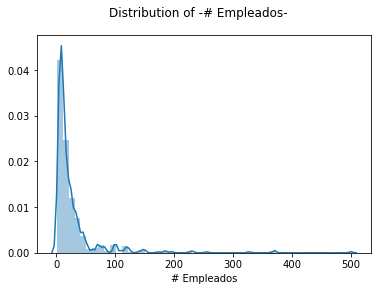

In [77]:
sns.distplot(clean_data['# Empleados'])
plt.suptitle('Distribution of -# Empleados-')

#### Analizing two variables

Text(0.5, 0.98, 'Ingresos vs total_paid')

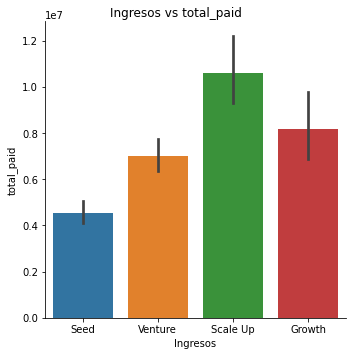

In [78]:
sns.catplot(x='Ingresos', y='total_paid', kind='bar', data=clean_data)
plt.suptitle('Ingresos vs total_paid')

Text(0.5, 0.98, 'Ingresos vs arrears_days')

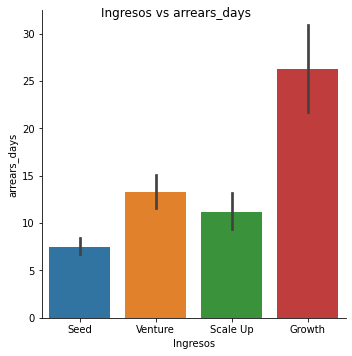

In [79]:
sns.catplot(x='Ingresos', y='arrears_days', kind='bar', data=clean_data)
plt.suptitle('Ingresos vs arrears_days')

Text(0.5, 0.98, 'Sector vs arrears_days')

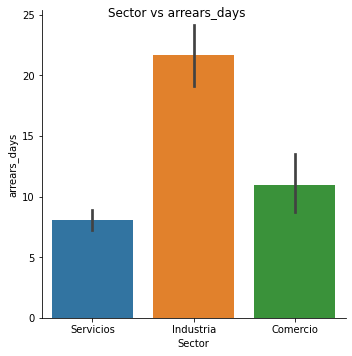

In [80]:
sns.catplot(x='Sector', y='arrears_days', kind='bar', data=clean_data)
plt.suptitle('Sector vs arrears_days')

Text(0.5, 0.98, 'Sector vs total_paid')

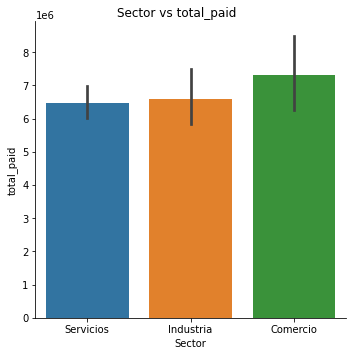

In [81]:
sns.catplot(x='Sector', y='total_paid', kind='bar', data=clean_data)
plt.suptitle('Sector vs total_paid')

Text(0.5, 0.98, 'Estrato Mínimo vs arrears_days')

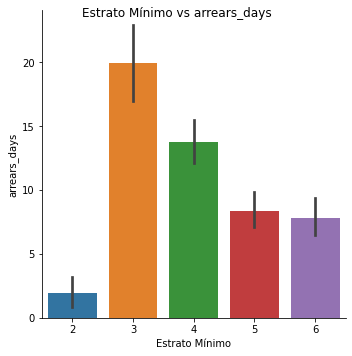

In [82]:
sns.catplot(x='Estrato Mínimo', y='arrears_days', kind='bar', data=clean_data)
plt.suptitle('Estrato Mínimo vs arrears_days')

Text(0.5, 0.98, 'Ingresos vs total_paid')

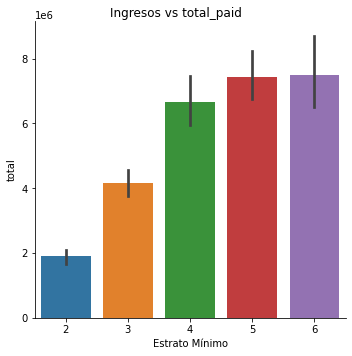

In [83]:
sns.catplot(x='Estrato Mínimo', y='total', kind='bar', data=clean_data)
plt.suptitle('Ingresos vs total_paid')

##### Q - Q

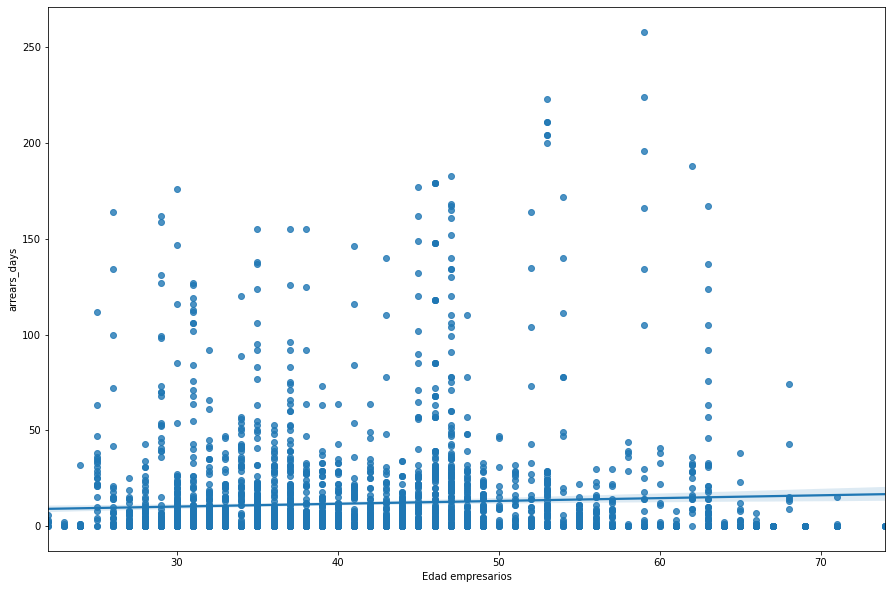

In [84]:
plt.figure(figsize=(15,10))
sns.regplot(x='Edad empresarios', y='arrears_days', data=clean_data)
plt.show()

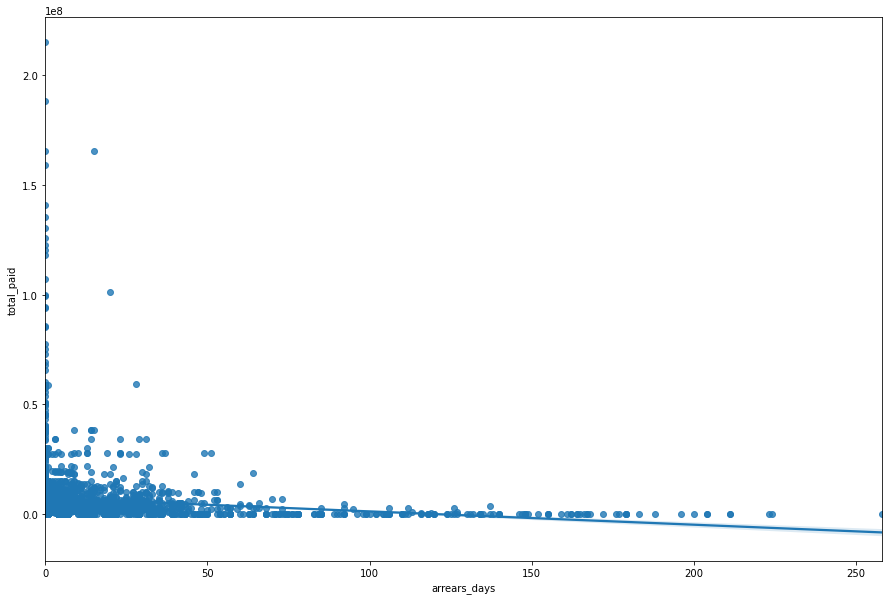

In [85]:
plt.figure(figsize=(15,10))
sns.regplot(y='total_paid', x='arrears_days', data=clean_data)
plt.show()

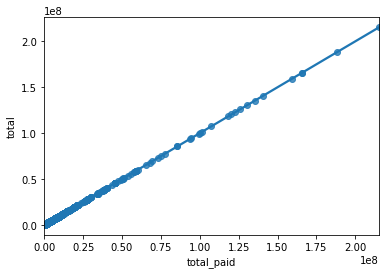

In [86]:
sns.regplot(x='total_paid', y='total', data=clean_data)

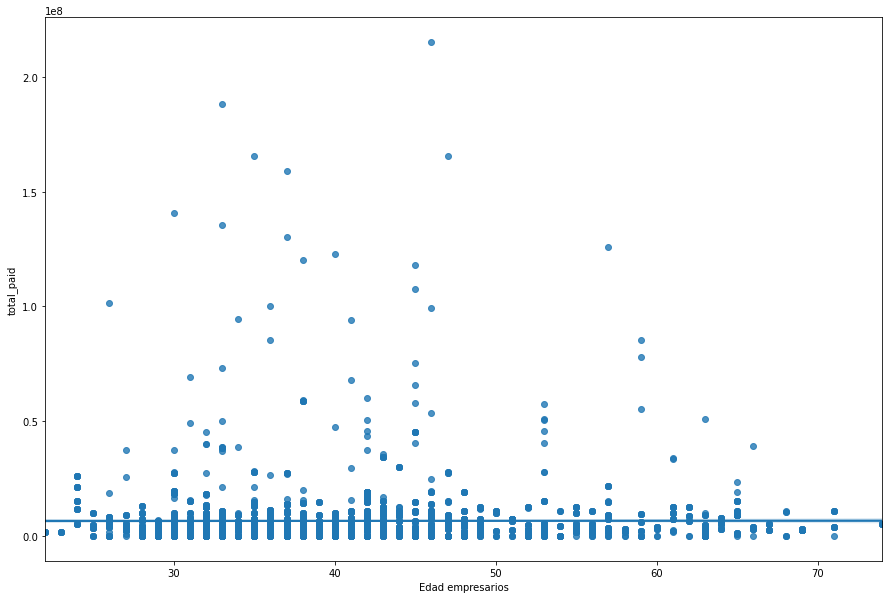

In [87]:
plt.figure(figsize=(15,10))
sns.regplot(x='Edad empresarios', y='total_paid', data=clean_data)
plt.show()

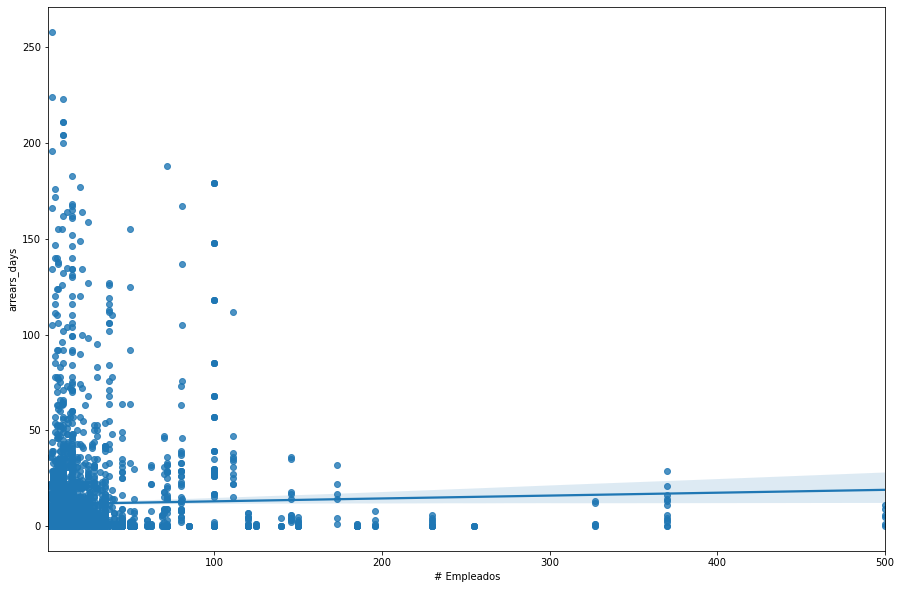

In [88]:
plt.figure(figsize=(15,10))
sns.regplot(x='# Empleados', y='arrears_days', data=clean_data)
plt.show()

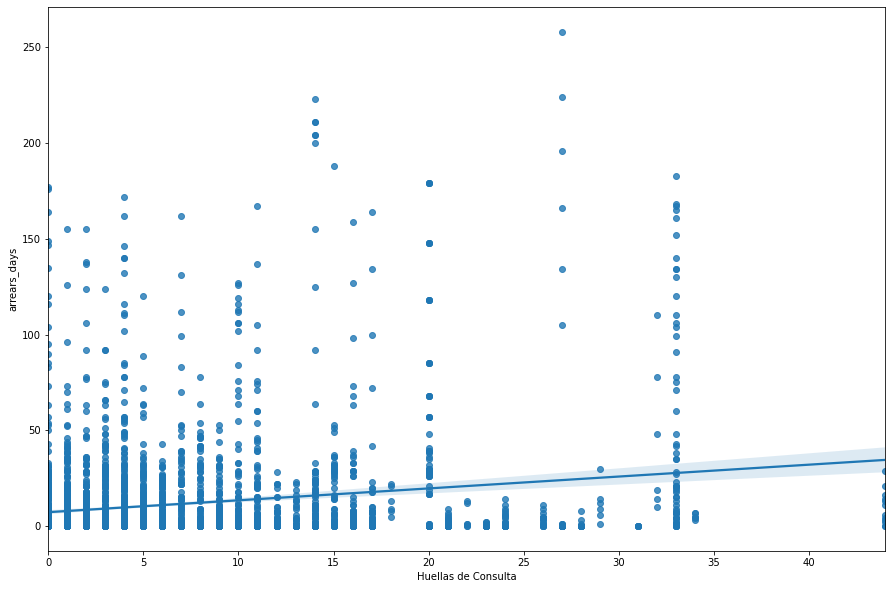

In [89]:
plt.figure(figsize=(15,10))
sns.regplot(x='Huellas de Consulta', y='arrears_days', data=clean_data)
plt.show()

#### C - C

In [90]:
clean_data.groupby('Ingresos')['Uso de los recursos'].value_counts()/len(clean_data)

Ingresos  Uso de los recursos
Growth    KT - CO                0.039861
          KT - EX                0.038128
          CR                     0.029463
Scale Up  KT - CO                0.071057
          KT - EX                0.057192
          CR                     0.022530
          SP                     0.008666
Seed      KT - EX                0.147314
          KT - CO                0.136915
          SP                     0.077990
          CR                     0.074523
Venture   KT - CO                0.126516
          KT - EX                0.105719
          CR                     0.036395
          SP                     0.027730
Name: Uso de los recursos, dtype: float64

In [91]:
clean_data.groupby('Ubicación')['Activador'].value_counts()/len(clean_data)

Ubicación            Activador                
Armenia              Other                        0.001733
Barranquilla         Other                        0.013865
                     CreditProfessionalContact    0.005199
                     Internet                     0.005199
                     Newspapers                   0.005199
                     Referrer                     0.005199
                     FriendOrColleague            0.001733
Bello                SocialNetworks               0.001733
Bogotá D.C.          FriendOrColleague            0.149047
                     Internet                     0.097054
                     Other                        0.048527
                     Newspapers                   0.038128
                     CreditProfessionalContact    0.029463
                     SocialNetworks               0.017331
                     Referrer                     0.013865
                     CommunicationMedia           0.010399
         

In [92]:
clean_data.groupby('Sector')['Ingresos'].value_counts()/len(clean_data)

Sector     Ingresos
Comercio   Seed        0.055459
           Venture     0.048527
           Growth      0.029463
           Scale Up    0.027730
Industria  Venture     0.088388
           Seed        0.069324
           Growth      0.041594
           Scale Up    0.041594
Servicios  Seed        0.311958
           Venture     0.159445
           Scale Up    0.090121
           Growth      0.036395
Name: Ingresos, dtype: float64

In [93]:
clean_data.groupby('Sector')['Uso de los recursos'].value_counts()/len(clean_data)

Sector     Uso de los recursos
Comercio   KT - CO                0.107452
           KT - EX                0.024263
           CR                     0.022530
           SP                     0.006932
Industria  KT - CO                0.074523
           KT - EX                0.069324
           CR                     0.055459
           SP                     0.041594
Servicios  KT - EX                0.254766
           KT - CO                0.192374
           CR                     0.084922
           SP                     0.065858
Name: Uso de los recursos, dtype: float64

In [94]:
clean_data.groupby('Sector')['Estrato Mínimo'].value_counts()/len(clean_data)

Sector     Estrato Mínimo
Comercio   5                 0.055459
           4                 0.050260
           3                 0.036395
           6                 0.017331
           2                 0.001733
Industria  4                 0.095321
           3                 0.055459
           5                 0.048527
           6                 0.038128
           2                 0.003466
Servicios  5                 0.211438
           4                 0.181976
           6                 0.133449
           3                 0.069324
           2                 0.001733
Name: Estrato Mínimo, dtype: float64

In [95]:
clean_data.columns

Index(['client_id', 'loan_schedule_id', 'loan_id', 'index', 'expected_date', 'state', 'arrears_days', 'total', 'total_paid', 'ID Cliente', 'Monto Acumulado', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo', 'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Tiempo en el negocio', 'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas', 'Impacto', 'Acceso previso a la banca', '# Empleados', 'Mujeres empresarias', 'Mujeres en cargos directivos'], dtype='object')

In [96]:
clean_data.groupby('arrears_days').describe()

client_id                                                                     loan_schedule_id                                                                            loan_id                                                                      index                                                         total                                                                                                 total_paid                                                                                                 ID Cliente                                                                     Monto Acumulado                                                                                                   Estrato Mínimo                                                Score Bureau Empresa                                                              Huellas de Consulta                                                       Tiempo en el negocio                                  \
                 count         mean          std     min      25%     50%      75%     max            count          mean           std      min       25%      50%       75%      max   count         mean         std     min      25%     50%      75%     max   count       mean        std   min    25%   50%    75%   max   count          mean           std         min           25%           50%           75%           max      count          mean           std         min           25%           50%           75%           max      count         mean          std     min      25%     50%      75%     max           count          mean           std           min           25%           50%           75%           max          count      mean       std  min   25%  50%   75%  max                count        mean         std    min     25%    50%     75%    max               count       mean        std   min    25%   50%    75%   max                count         mean        std     min   
arrears_days                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
0               1537.0  2613.614183  1616.746989   241.0  1467.00  2440.0  3780.00  7279.0           1537.0  23432.010410  10069.020732     58.0  15446.00  26899.0  31344.00  37873.0  1537.0   996.130774  413.949424    11.0   668.00  1138.0  1324.00  1600.0  1537.0   9.660377   5.334313   2.0   6.00   9.0  12.00  36.0  1537.0  8.751360e+06  1.619811e+07    11222.84  2.693660e+06  4.622812e+06  9.110987e+06  2.152136e+08     1537.0  8.751507e+06  1.619839e+07    11222.84  2.693660e+06  4.622812e+06  9.110987e+06  2.152136e+08     1537.0  2613.614183  1616.746989   241.0  1467.00  2440.0  3780.00  7279.0          1537.0  3.066242e+08  2.933446e+08  3.000000e+07  1.100000e+08  2.000000e+08  3.800000e+08  1.299371e+09         1537.0  4.620690  0.974232  2.0  4.00  5.0  5.00  6.0               1537.0  841.276513  200.401861    0.0  860.00  906.0  933.00  982.0              1537.0   6.621340   6.951638   0.0   2.00   4.0  10.00  44.0               1537.0  2010.420950   7.742295  1958.0   
1                314.

In [97]:
clean_data.groupby('arrears_days').corr()

client_id  loan_schedule_id   loan_id     index     total  total_paid  ID Cliente  Monto Acumulado  Estrato Mínimo  Score Bureau Empresa  Huellas de Consulta  Tiempo en el negocio  Edad empresarios  Número de accionistas  # Empleados  Mujeres en cargos directivos
arrears_days                                                                                                                                                                                                                                                                                                      
0            client_id                      1.000000          0.534638  0.540347 -0.371877 -0.118336   -0.118340    1.000000        -0.380089       -0.159762             -0.074042            -0.147789              0.045153          0.069303              -0.039856    -0.016634                      0.025025
             loan_schedule_id               0.534638          1.000000  0.999193 -0.553651 -0.127508   -0.127497    0.534638        -0.345045       -0.159856             -0.093050            -0.094095              0.095349          0.049996              -0.016839    -0.038480                     -0.004444
             loan_id                        0.540347          0.999193  1.000000 -0.555882 -0.128158   -0.128147    0.540347        -0.346258       -0.158510             -0.089807            -0.096103              0.099128          0.047642              -0.017282    -0.038899                     -0.004270
             index                         -0.371877         -0.553651 -0.555882  1.000000  0.068867    0.068861   -0.371877         0.203295        0.129034              0.007243             0.058628              0.015807         -0.029143               0.046566     0.017520                     -0.061460
             total                         -0.118336         -0.127508 -0.128158  0.068867  1.000000    1.000000   -0.118336         0.254868        0.062035              0.063291             0.154256             -0.094295          0.001740               0.073121     0.127236                      0.055012
...                                              ...               ...       ...       ...       ...         ...         ...              ...             ...                   ...                  ...                   ...               ...                    ...          ...                           ...
258          Tiempo en el negocio                NaN               NaN       NaN       NaN       NaN         NaN         NaN              NaN             NaN                   NaN                  NaN                   NaN               NaN                    NaN          NaN                           NaN
             Edad empresarios                    NaN               NaN       NaN       NaN       NaN         NaN         NaN              NaN             NaN                   NaN                  NaN                   NaN               NaN                    NaN          NaN                           NaN
             Número de accionistas               NaN               NaN       NaN       NaN       NaN         NaN         NaN              NaN             NaN                   NaN                  NaN                   NaN               NaN                    NaN          NaN                           NaN
             # Empleados                         NaN               NaN       NaN       NaN       NaN         NaN         NaN              NaN             NaN                   NaN                  NaN                   NaN               NaN                    NaN          NaN                           NaN
             Mujeres en cargos directivos        NaN               NaN       NaN       NaN       NaN         NaN         NaN              NaN             NaN                   NaN                  NaN                   NaN               NaN                    NaN          NaN                           NaN

[2208 rows x 16 columns]

In [98]:
clean_data.shape

(3462, 34)

In [99]:
clean_data_copy = clean_data.copy()

In [100]:
# Inferencial statistics

# Hypothesis testing:
# 1. define null hypothesis and alternate hypothesis
# 2. Choose sample
# 3. Analyse evidence
# 4. Interpret results

# H0: There is no relationship between the explanatory and response 
# H1: There is a statistically significant relationship

# Bivariate statistical tools:
# Anova; chi-square; correlation coefficient 

In [101]:
# Explanatory cathegorical and response quantitative: ANOVA
# Explanatory cathegorical and response cathegorical: Chi Square test
# Explanatory quantitative and response cathegorical: classify/bin explanatory
# Explanatory quantitative and response quantitative: Pearson correlation

In [102]:
# ANOVA table
test1 = smf.ols(formula = 'arrears_days ~ C(Sector)', data=clean_data_copy).fit()
print(test1.summary())

                            OLS Regression Results                            
Dep. Variable:           arrears_days   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     80.70
Date:                Tue, 06 Oct 2020   Prob (F-statistic):           5.56e-35
Time:                        10:33:41   Log-Likelihood:                -16219.
No. Observations:                3462   AIC:                         3.244e+04
Df Residuals:                    3459   BIC:                         3.246e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 10

In [103]:
# Now we check mean and stardard deviation
grouped1_mean = clean_data_copy.groupby('Sector').mean()['arrears_days']
print(grouped1_mean)

Sector
Comercio     10.924731
Industria    21.713429
Servicios     8.087440
Name: arrears_days, dtype: float64


In [104]:
grouped1_std = clean_data_copy.groupby('Sector').std()['arrears_days']
print(grouped1_std)

Sector
Comercio     28.043082
Industria    38.075689
Servicios    18.801334
Name: arrears_days, dtype: float64


In [105]:
tuckey1 = multi.MultiComparison(clean_data_copy['arrears_days'], clean_data_copy['Sector'])
res1 = tuckey1.tukeyhsd()
print(res1.summary())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
 Comercio Industria  10.7887  0.001   7.427 14.1504   True
 Comercio Servicios  -2.8373 0.0604 -5.7692  0.0946  False
Industria Servicios  -13.626  0.001 -16.147 -11.105   True
----------------------------------------------------------


In [106]:
# Second Hypothesis
test2 = smf.ols(formula = 'arrears_days ~ C(Ingresos)', data=clean_data_copy).fit()
print(test2.summary())

                            OLS Regression Results                            
Dep. Variable:           arrears_days   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     52.62
Date:                Tue, 06 Oct 2020   Prob (F-statistic):           2.97e-33
Time:                        10:33:41   Log-Likelihood:                -16221.
No. Observations:                3462   AIC:                         3.245e+04
Df Residuals:                    3458   BIC:                         3.247e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [107]:
# Now we check mean and stardard deviation
grouped2_mean = clean_data_copy.groupby('Ingresos').mean()['arrears_days']
print(grouped2_mean)

Ingresos
Growth      26.279570
Scale Up    11.213768
Seed         7.488757
Venture     13.310916
Name: arrears_days, dtype: float64


In [108]:
grouped2_std = clean_data_copy.groupby('Ingresos').std()['arrears_days']
print(grouped2_std)

Ingresos
Growth      45.356656
Scale Up    23.835598
Seed        16.577113
Venture     29.431157
Name: arrears_days, dtype: float64


In [109]:
tuckey2 = multi.MultiComparison(clean_data_copy['arrears_days'], clean_data_copy['Ingresos'])
res2 = tuckey2.tukeyhsd()
print(res2.summary())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj   lower    upper   reject
----------------------------------------------------------
  Growth Scale Up -15.0658  0.001 -19.5884 -10.5432   True
  Growth     Seed -18.7908  0.001 -22.6928 -14.8888   True
  Growth  Venture -12.9687  0.001 -17.0491  -8.8882   True
Scale Up     Seed   -3.725 0.0224  -7.0778  -0.3722   True
Scale Up  Venture   2.0971 0.4303  -1.4617    5.656  False
    Seed  Venture   5.8222  0.001   3.0951   8.5492   True
----------------------------------------------------------


In [110]:
# Explanatory quantitative and response quantitative: Pearson correlation

# The r coefficient is a measure of association 
# correlation are always between -1 and 1
# r measure solely linear association

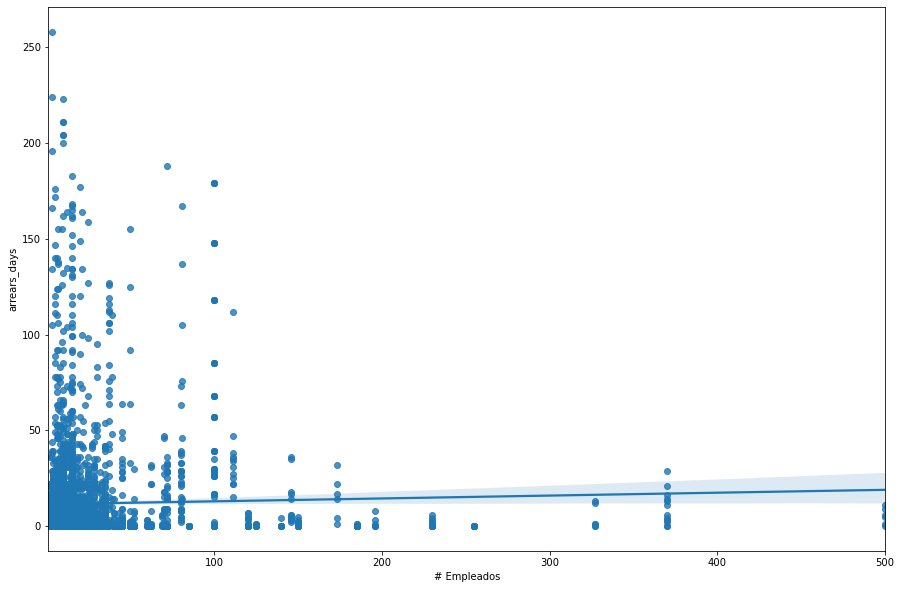

In [111]:
plt.figure(figsize=(15,10))
sns.regplot(x='# Empleados', y='arrears_days', data=clean_data)
plt.show()

In [112]:
print('Association between # empleados and arrears_days')
print(scipy.stats.pearsonr(clean_data_copy['arrears_days'], clean_data_copy['# Empleados']))

Association between # empleados and arrears_days
(0.02515363709010059, 0.13895105003538186)


In [113]:
# Pearson test tell us that # Empleados and arrears_days are independent from each other

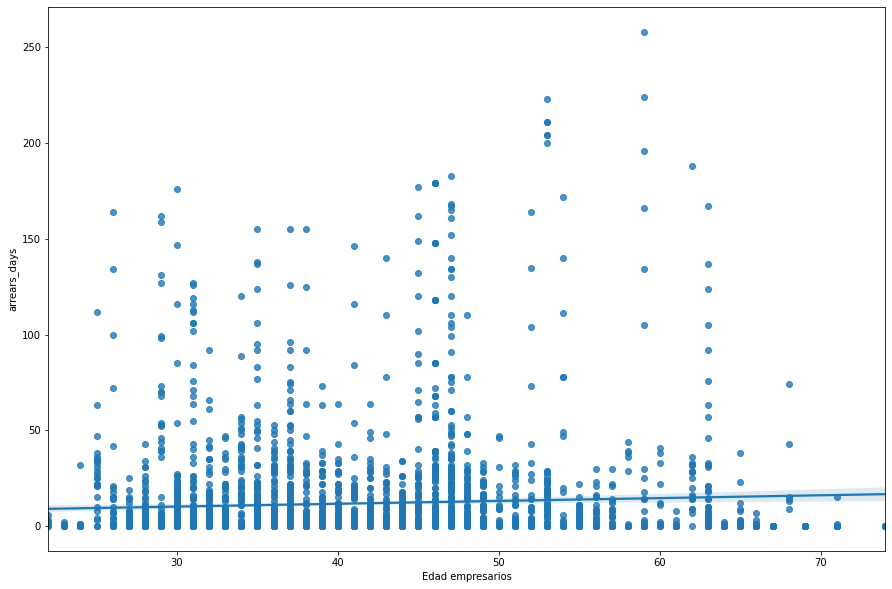

In [114]:
plt.figure(figsize=(15,10))
sns.regplot(x='Edad empresarios', y='arrears_days', data=clean_data)
plt.show()

In [115]:
print('Association between Edad empresarios and arrears_days')
print(scipy.stats.pearsonr(clean_data_copy['arrears_days'], clean_data_copy['Edad empresarios']))

Association between Edad empresarios and arrears_days
(0.05550168108911206, 0.0010869782439405593)


In [116]:
# Pearson correlation tell us that arrears_days and Edad empresarios are dependent from each other

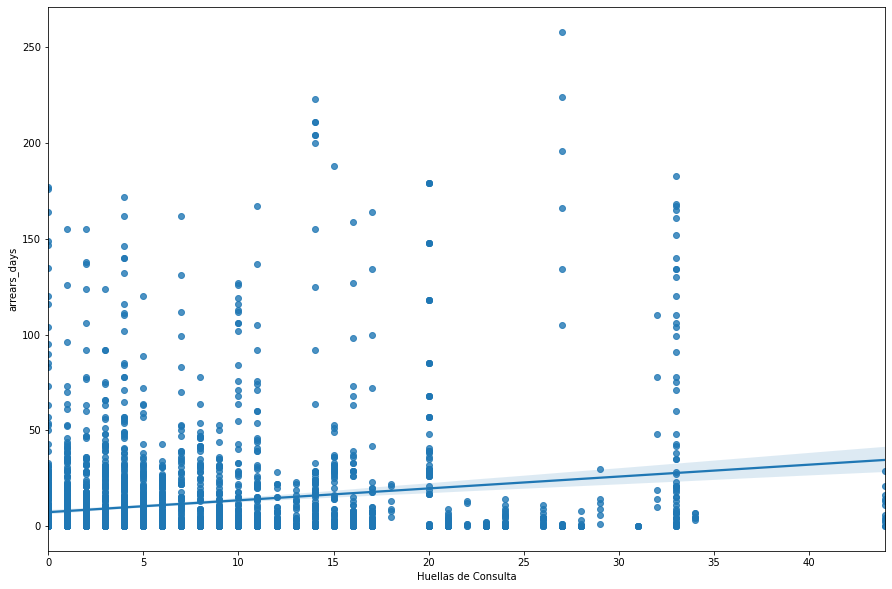

In [117]:
plt.figure(figsize=(15,10))
sns.regplot(x='Huellas de Consulta', y='arrears_days', data=clean_data)
plt.show()

In [118]:
print('Association between Huellas de Consulta and arrears_days')
print(scipy.stats.pearsonr(clean_data_copy['arrears_days'], clean_data_copy['Huellas de Consulta']))

Association between Huellas de Consulta and arrears_days
(0.17933405921342033, 2.0636471183957074e-26)


In [119]:
# Pearson correlation tell us that Huellas de Consulta and arrears_days are dependent from each other

In [120]:
# -------------------------------------------------------------

In [121]:
norm_data = pd.DataFrame()
cat_cols = ['ID Cliente', 'Monto Acumulado', 'Uso de los recursos', 'Plazo',
       'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo',
       'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Tiempo en el negocio',
       'Website empresa', 'Instagram empresa', 'LinkedIn empresa',
       'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas',
       'Impacto', 'Acceso previso a la banca', '# Empleados',
       'Mujeres empresarias', 'Mujeres en cargos directivos']
norm_data = clean_data.drop(columns=cat_cols)

In [122]:
norm_data.to_excel('six_loan_id.xlsx')

In [123]:
norm_data.head(2)

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,total,total_paid
0,241,25718,1076,8,2019-08-14,PAID,16,5947504.88,5947504.88
1,241,25719,1076,9,2019-09-16,PAID,1,5972929.73,5972929.73


In [124]:
norm_data.shape

(3462, 9)

In [125]:
norm_data['loan_id'].value_counts()

1595    6
11      6
1264    6
1262    6
1260    6
       ..
973     6
971     6
903     6
839     6
20      6
Name: loan_id, Length: 577, dtype: int64

In [126]:
info = clean_data.corr()

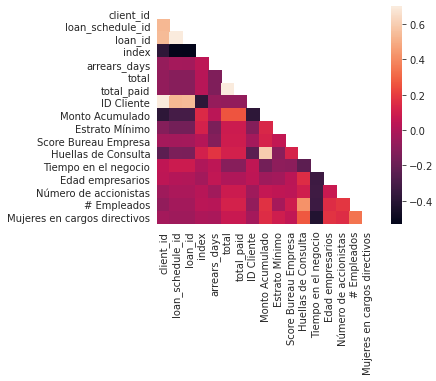

In [127]:
mask=np.zeros_like(info,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style("white"):
    a=sns.heatmap(info,mask=mask,vmax=0.7,square=True)